In [1]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import scipy.stats
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as u

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

In [2]:
d = pickle.load(open("fitter_params.pickle"))
F = threebody.Fitter(**d)
params = d

In [3]:
F.residuals(F.best_parameters)

array([-0.00042220717,  0.00024635694, -0.00072789053, ..., -0.00029530004,
       -0.001845818, -0.0015876219], dtype=float128)

In [4]:
vals, names = F.compute_linear_parts(F.best_parameters)
lp = dict(zip(names, vals))
der = dict(zip(F.jnames, F.jmatrix.T))

In [5]:
d = dict()
d.update(der)
res = F.residuals(F.best_parameters)
d["resid_phase"] = res
d["resid_s"] = res/F.reference_f0
d["uncert_phase"] = F.uncerts
toa_info = F.annotated_toas(d)

## Adjusting DM

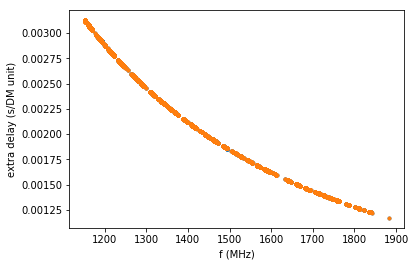

In [6]:
freqs = np.array([t["freq"] for t in toa_info])
d_DMs = np.array([float(t["flags"]["d_DM"]) for t in toa_info])
fmla = 4.15e6/freqs**2 * 1e-3

plt.plot(freqs, fmla,".")
plt.plot(freqs, d_DMs,".")
plt.xlabel("f (MHz)")
plt.ylabel("extra delay (s/DM unit)")

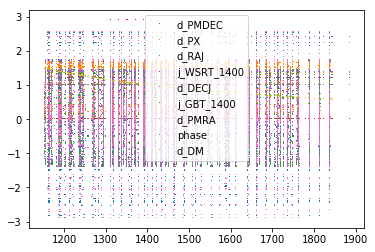

In [7]:
for k in der:
    d = der[k]
    d /= np.sqrt(np.mean(d**2))
    plt.plot(freqs, d, ",", label=k)
plt.legend(loc="upper center")

We have the derivative of delay, in seconds, with respect to DM, stored in `d_DM`. We solved for the constant `c` that made `c*d_DM` line up with our residuals, measured in phase. So `(c/f0)*d_DM` should line up with our residuals in seconds, and so the actual change in DM called for should be `c/f0` DM units. 

In [8]:
# The fit was to phase not seconds; check correction factor and sign
dm_correction = lp["d_DM"]/F.reference_f0 
print dm_correction, "pc/cm^3"


1.49558585869e-05 pc/cm^3


(21.315933, 21.315918044141414184)
(42794.255002379104216, 42794.804170760520002)
1.49558585869e-05 -4.57621472404e-08
1.49558585869e-05 -1.50016207342e-05


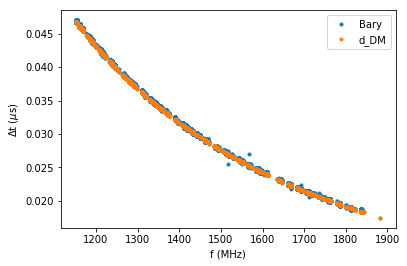

In [9]:
par = params["parfile"]
par2 = par[:par.rindex(".")]+"_dmcorr_2.par"
with open(par2, "wt") as f:
    for l in open(par, "rt").readlines():
        if l.startswith("DM"):
            dm = float(l.split()[1])
            dm2 = dm-dm_correction
            print(dm, dm2)
            f.write("DM %f\n" % dm2)
        else:
            f.write(l)

params2 = params.copy()
params2["parfile"] = par2
F2 = threebody.Fitter(**params2)
print(F.goodness_of_fit(F.best_parameters), 
      F2.goodness_of_fit(F.best_parameters))
vals, names = F2.compute_linear_parts(F.best_parameters)
lp2 = dict(zip(names, vals))
print lp["d_DM"]/F.reference_f0, lp2["d_DM"]/F.reference_f0
print dm_correction, (lp2["d_DM"]-lp["d_DM"])/F.reference_f0

plt.plot(freqs, 1e6*(F2.mjds-F.mjds)*86400, ".", label="Bary")
plt.plot(freqs, 1e6*d_DMs*dm_correction, ".", label="d_DM")
plt.xlabel("f (MHz)")
plt.ylabel(r"$\Delta$t ($\mu$s)")
plt.legend()



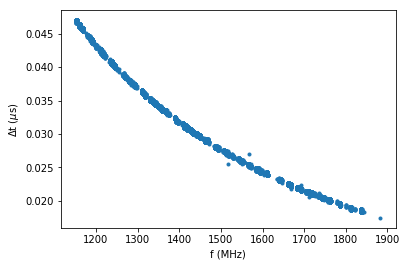

In [10]:
orbit = F.compute_orbit(F.best_parameters)
orbit2 = F2.compute_orbit(F.best_parameters)

t_psr = orbit['t_psr']
t_psr2 = orbit2['t_psr']

plt.plot(freqs, 1e6*(t_psr2-t_psr)*86400, ".")
plt.xlabel("f (MHz)")
plt.ylabel(r"$\Delta$t ($\mu$s)")


## Getting errors on the linear parts

In [11]:
A, lp = F.compute_linear_matrix(F.best_parameters)

In [12]:
scipy.linalg.svdvals(A)

array([  1.88496246e+18,   3.73212964e+09,   2.74870927e+02,
         1.83690198e+02,   1.69591058e+02,   1.20844210e+02,
         1.08607004e+02,   6.95639309e+01,   3.83266948e+01,
         1.95316703e+01,   4.26695924e+00])

The condition number of A is absolutely huge, limited only by the numerical accuracy. So we need to do something if we hope to get anything meaningful out of numerical linear algebra. Fortunately most of the problem comes from the scales of the columns of A: rescaling them can dramatically improve the condition number.

In [13]:
Ascales = np.sqrt(np.sum(A**2,axis=0))
As = A/Ascales[None,:]
scipy.linalg.svdvals(As)

array([ 2.20464615,  1.65898272,  1.10453614,  1.06604355,  0.7359492 ,
        0.53082474,  0.3820708 ,  0.16684758,  0.13443276,  0.10142139,
        0.07274595])

Now, we want error estimates, or specifically, a covariance matrix. This is classically given by $(A^T A)^{-1}$. Of course, this has condition number roughly the square of $A$, so computing it directly is a disaster. But we already established that there's a diagonal matrix S so that $AS^{-1}$ is much better-conditioned. And 
$$
(A^TA)^{-1} = S^{-1}((AS^{-1})^T(AS^{-1}))^{-1}S^{-1}
$$

In [14]:
Atas = np.dot(As.T, As)
covs = scipy.linalg.pinv(Atas)
cov = covs/Ascales[:,None]/Ascales[None,:]
cov[0,0]

0.001963246784233356137

In [15]:
r = threebody.lstsq_with_errors(A, F.residuals(), F.phase_uncerts)


In [16]:
for i, n in enumerate(lp):
    print n, threebody.fmt(r.x[i], r.uncerts[i])

d_DECJ 0(13)e-6
d_DM 0(6)e-6
d_PMDEC 0(13)e-6
d_PMRA 0(13)e-6
d_PX 0(3)e-6
d_RAJ 0(13)e-6
f0 0(17)e-14
f1 0(10)e-22
j_GBT_1400 0(3)e-6
j_WSRT_1400 0(3)e-6
phase 0(8)e-6


## Frequency dependence parameters

The idea here is to use an F test on the linear fit to ask how many linear parameters are needed. Note that if you don't apply an EFAC but it's needed then the F scores are going to look more unlikely than they are.

In [23]:
A, lp = F.compute_linear_matrix(F.best_parameters)

In [24]:
cols = {}
for n, col in zip(lp,A.T):
    if False and n=="d_DM":
        d_DM = col
    else:
        cols[n] = col


In [25]:
for i in range(1,10):
    cols["FD%d"%i] = np.log(freqs/1000.)**i

In [26]:
names = sorted(cols.keys())
Abig = np.array([cols[n] for n in names]).T
r = threebody.lstsq_with_errors(Abig, F.residuals(), F.phase_uncerts)
for i, n in enumerate(names):
    print n, threebody.fmt(r.x[i], r.uncerts[i])

FD1 9(6)e-1
FD2 -1.4(8)e1
FD3 1.0(5)e2
FD4 -4(2)e2
FD5 1.2(7)e3
FD6 -2.3(14)e3
FD7 2.6(16)e3
FD8 -1.7(11)e3
FD9 5(3)e2
d_DECJ 0(13)e-6
d_DM -8(4)e-2
d_PMDEC 0(13)e-6
d_PMRA 0(13)e-6
d_PX -1(3)e-6
d_RAJ 1.0(15)e-5
f0 0(17)e-14
f1 0(10)e-22
j_GBT_1400 9(4)e-6
j_WSRT_1400 -1.7(3)e-5
phase 1.2(9)e-1


In [27]:
r.x

array([ 0.86223621, -14.283144,  101.76975, -442.85104,  1243.6383,
       -2263.2932,  2581.0173, -1677.5911,  474.54093,  2.013924e-06,
       -0.08061455,  7.2512439e-06, -8.3274179e-06, -1.3295729e-06,
        1.0080276e-05,  3.8098655e-14, -3.6770321e-22,  8.9872094e-06,
       -1.7258872e-05,  0.11705025], dtype=float128)

In [28]:
def A_fd(n):
    cols = {}
    for nm, col in zip(lp,A.T):
        cols[nm] = col
    for i in range(1,n+1):
        cols["FD%d"%i] = np.log(freqs/1000.)**i
    names = sorted(cols.keys())
    Abig = np.array([cols[n] for n in names]).T
    return Abig, names

res = F.residuals()
chi2 = np.sum((res/F.phase_uncerts)**2)
Abig, names = A_fd(0)
n = Abig.shape[0]
r = threebody.lstsq_with_errors(Abig, res, F.phase_uncerts)
last_chi2 = r.chi2
np_base = len(F.parameters)+len(lp)
for i in range(1,15):
    Abig, names = A_fd(i)
    r = threebody.lstsq_with_errors(Abig, res, F.phase_uncerts)
    f = ((last_chi2-r.chi2))/(last_chi2/(n-np_base-i))
    f_fpp = scipy.stats.f(1,n-np_base-i).sf(float(f))
    last_chi2 = r.chi2
    
    print("up to FD%d F score: %f f FPP: %f chi2: %f"
          %(i, f, f_fpp, r.chi2))
    

up to FD1 F score: 785.194077 f FPP: 0.000000 chi2: 41572.676164
up to FD2 F score: 6.472262 f FPP: 0.010963 chi2: 41562.894672
up to FD3 F score: 7.018510 f FPP: 0.008072 chi2: 41552.289750
up to FD4 F score: 4.082185 f FPP: 0.043347 chi2: 41546.122946
up to FD5 F score: 0.831191 f FPP: 0.361936 chi2: 41544.867438
up to FD6 F score: 2.295572 f FPP: 0.129755 chi2: 41541.399970
up to FD7 F score: 0.488884 f FPP: 0.484432 chi2: 41540.661545
up to FD8 F score: 2.630492 f FPP: 0.104841 chi2: 41536.688293
up to FD9 F score: 1.410878 f FPP: 0.234921 chi2: 41534.557346
up to FD10 F score: 6.860526 f FPP: 0.008817 chi2: 41524.195567
up to FD11 F score: 0.002032 f FPP: 0.964048 chi2: 41524.192499
up to FD12 F score: 0.566546 f FPP: 0.451641 chi2: 41523.336970
up to FD13 F score: 1.909130 f FPP: 0.167071 chi2: 41520.453984
up to FD14 F score: 14.741024 f FPP: 0.000124 chi2: 41498.194236
